In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Prevent warning messages (which are quite long)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="With alpha=0, this algorithm does not converge well.")
warnings.filterwarnings("ignore", message="Coordinate descent with no regularization may lead to unexpected results and is discouraged.")

#### Q9
In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [2]:
College = pd.read_csv("College.csv")
# Changing the college name from a predictor to just the index
College = College.set_index(['Unnamed: 0']).rename_axis('College')

# Changing qualitative variables to quantitative variables for regression (creating dummy variable)
College['Private'] = College['Private'].replace({'Yes':1,'No':0}).astype(int)

print("There are a total of {0} predictors".format(College.shape[1]))
College.head()

There are a total of 18 predictors


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
College,,,,,,,,,,,,,,,,,,
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


(a) Split the data set into a training set and a test set.

In [3]:
X = College.drop(columns='Apps')
y = College['Apps']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.8,random_state=0)
results = pd.DataFrame({'Model': ['Linear Regression', 'Ridge Regression', 'Lasso', 'PCR', 'PLS'],
                        'MSE': [0, 0, 0, 0, 0]})

(b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [4]:
lr = LinearRegression()
lr.fit(X_train,y_train)

pred_lr = lr.predict(X_test)
error_lr = round(np.sqrt(mean_squared_error(pred_lr, y_test)),2)
results.loc[0,"MSE"] = float(error_lr)

print("The RMSE test error for simple linear regression is {0}".format(error_lr))

The RMSE test error for simple linear regression is 1400.77


(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

The lowest MSE is 1134.6127028966139 and is achieved at lambda = 15.07537688442211


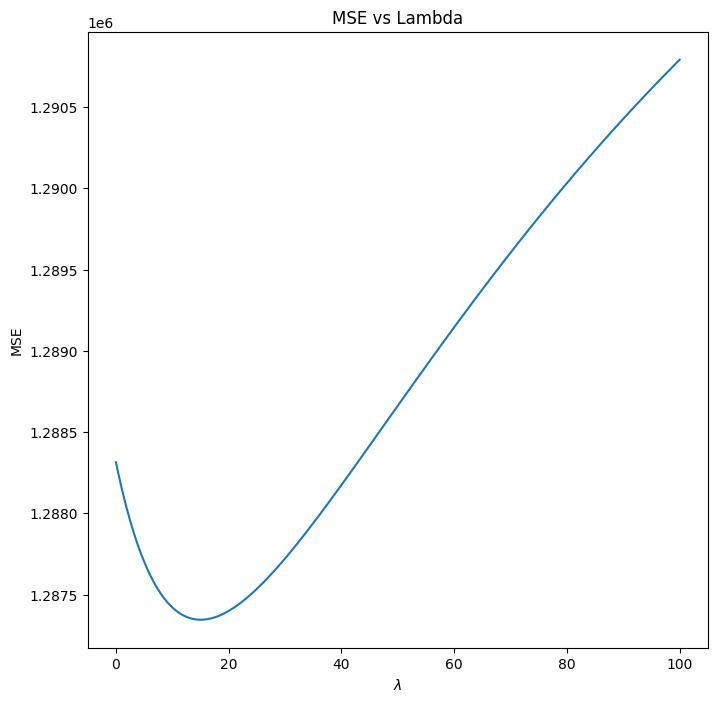

In [5]:
# Function to find the best lambda value using k-fold cross-validation
def tune_model(lambdas, X, y, K, model_class):
    results = pd.DataFrame(columns=['Alpha', 'MSE'])
    for alpha in lambdas:
        # Initialize the model with the current alpha (lambda) value
        model = model_class(alpha=alpha)
        # Calculate cross-validation scores using negative mean squared error
        scores = cross_val_score(model, X, y, cv=K, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)  # Make errors positive
        # Append the values to results 
        new_row = pd.DataFrame({'Alpha': [alpha], 'MSE': [mse]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results
    
# Define the range of lambda (alpha) values to test
lambdas_rr = np.linspace(0, 100, 200)

# Finding variation in MSE for ridge regression 
results_rr = tune_model(lambdas_rr, X, y, 10, Ridge)

# Find the lambda with the lowest MSE --> optimal lambda value 
min_mse_index_rr = results_rr['MSE'].idxmin()
min_mse_row_rr = results_rr.loc[min_mse_index_rr]
mse_min_rr, lambda_best_rr = min_mse_row_rr['MSE'], min_mse_row_rr['Alpha']
print("The lowest MSE is {0} and is achieved at lambda = {1}".format(np.sqrt(mse_min_rr), lambda_best_rr))

# Plot the variation in MSE as a function of lambda
plt.figure(figsize=(8, 8))
plt.plot(results_rr['Alpha'], results_rr['MSE'])
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('MSE vs Lambda')
plt.show()

In [6]:
# Use the optimal value of lambda to make predictions 
best_ridge = Ridge(alpha=lambda_best_rr)
best_ridge.fit(X_train,y_train)

pred_rr = best_ridge.predict(X_test)
error_rr = round(np.sqrt(mean_squared_error(pred_rr, y_test)),2)
results.loc[1,"MSE"] = float(error_rr)

print("The RMSE test error of ridge regression is {0}".format(error_rr))

The RMSE test error of ridge regression is 1404.41


(d) Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

The lowest MSE is 1134.8920777536403 and is achieved at lambda = 4.673366834170854


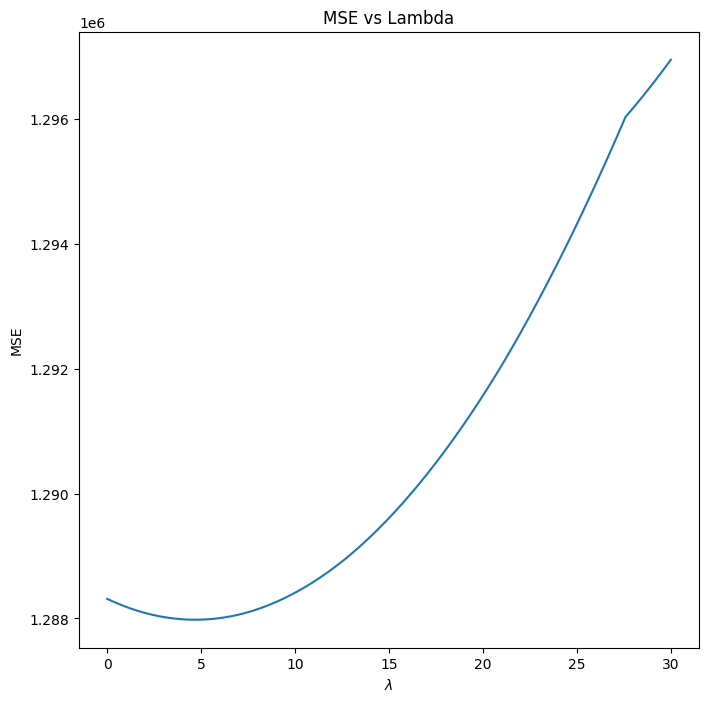

In [7]:
lambdas_l=np.linspace(0, 30, 200)
results_l = tune_model(lambdas_l, X, y, 10, Lasso)

# Find the lambda with the lowest MSE --> optimal lambda value 
min_mse_index_l = results_l['MSE'].idxmin()
min_mse_row_l = results_l.loc[min_mse_index_l]
mse_min_l, lambda_best_l = min_mse_row_l['MSE'], min_mse_row_l['Alpha']
print("The lowest MSE is {0} and is achieved at lambda = {1}".format(np.sqrt(mse_min_l), lambda_best_l))

# Plot the variation in MSE as a function of lambda
plt.figure(figsize=(8, 8))
plt.plot(results_l['Alpha'], results_l['MSE'])
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('MSE vs Lambda')
plt.show()

In [8]:
# Use the best value of lambda to make predictions
best_lasso = Lasso(alpha=lambda_best_l)
best_lasso.fit(X_train,y_train)

pred_l = best_lasso.predict(X_test)
error_l = round(np.sqrt(mean_squared_error(pred_l, y_test)),2)
results.loc[2,"MSE"] = float(error_l)

print("The RMSE test error of lasso is {0}".format(error_l))
print("There are {0} non-zero coefficients".format(17-np.sum(best_lasso.coef_ == 0))) 
# At higher values of lambda (250) coefficients begin to become 0

The RMSE test error of lasso is 1400.71
There are 17 non-zero coefficients


(e) Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

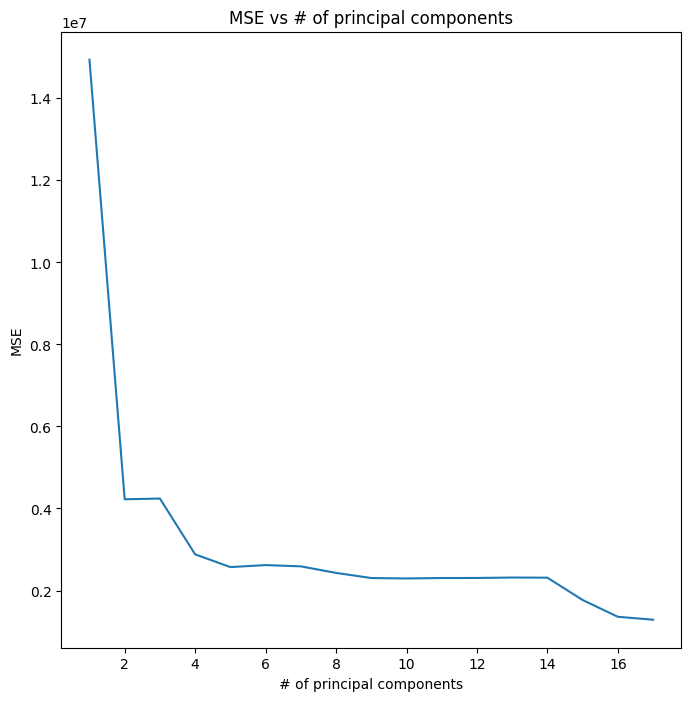

In [9]:
# Function to find the best value of M using k folds cross-validation
def tune_PCR(X,y,K):
    results = pd.DataFrame(columns=['M', 'MSE'])
    for m in range(1,18): # There are a total of 17 predictors 
        pca = PCA(n_components=m) # Find the first m principal components 
        X_reduced = pca.fit_transform(scale(X)) 
        model = LinearRegression() # Fit linear regression on the principal components 
        scores = cross_val_score(model, X_reduced, y, cv=K, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)
        new_row = pd.DataFrame({'M': [m], 'MSE': [mse]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results

results_pcr = tune_PCR(X,y,10)

# Plotting the results
plt.figure(figsize=(8, 8))
plt.plot(results_pcr['M'], results_pcr['MSE'])
plt.xlabel('# of principal components')
plt.ylabel('MSE')
plt.title('MSE vs # of principal components')
plt.show()

In [10]:
# Use the best value of M to make predictions 
pca = PCA(n_components=15)
X_train_reduced = pca.fit_transform(scale(X_train))
X_test_reduced = pca.transform(scale(X_test))

lr = LinearRegression()
lr.fit(X_train_reduced,y_train)

pred_pcr = lr.predict(X_test_reduced)
error_pcr = round(np.sqrt(mean_squared_error(pred_pcr, y_test)),2)
results.loc[3,"MSE"] = float(error_pcr)

print("The RMSE test error for principal components regression is {0}".format(error_pcr))

The RMSE test error for principal components regression is 1484.52


(f) Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

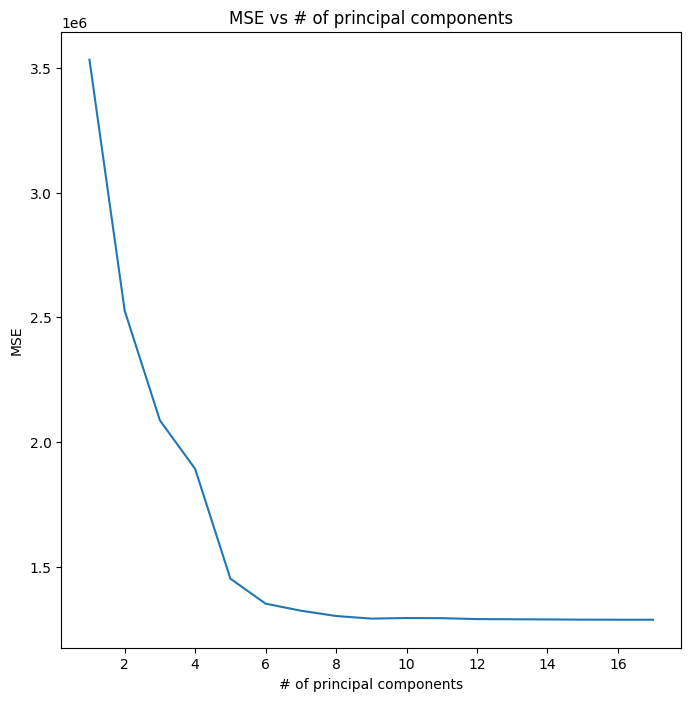

In [11]:
# Function to find the best value of M using k folds cross validation
def tune_PCL(X,y,K):
    results = pd.DataFrame(columns=['M', 'MSE'])
    for m in range(1,18): # There are a total of 17 predictors  
        model = PLSRegression(n_components=m)
        scores = cross_val_score(model, X, y, cv=K, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)
        new_row = pd.DataFrame({'M': [m], 'MSE': [mse]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results

results_pcl = tune_PCL(X,y,10)

# Plotting the results
plt.figure(figsize=(8, 8))
plt.plot(results_pcl['M'], results_pcl['MSE'])
plt.xlabel('# of principal components')
plt.ylabel('MSE')
plt.title('MSE vs # of principal components')
plt.show()

In [12]:
# Use the best value of M to make predictions
pls = PLSRegression(n_components=10)
pls.fit(X_train,y_train)

pred_pcl = pls.predict(X_test)
error_pcl = round(np.sqrt(mean_squared_error(pred_pcl, y_test)),2)
results.loc[4,"MSE"] = float(error_pcl)

print("The RMSE test error for partial least squares is {0}".format(error_pcl))

The RMSE test error for partial least squares is 1404.45


(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

In [13]:
results.sort_values(by=['MSE']).reset_index(drop=True)

,Model,MSE
0,Lasso,1400.71
1,Linear Regression,1400.77
2,Ridge Regression,1404.41
3,PLS,1404.45
4,PCR,1484.52


In [14]:
print("The mean in college applications is {0} with a standard deviation of {1}" 
      .format(np.mean(College['Apps']),np.std(College['Apps'])))
print("Our best prediction has mean {0} with a standard deviation of {1}" 
      .format(np.mean(pred_l),np.std(pred_l)))

The mean in college applications is 3001.6383526383524 with a standard deviation of 3867.7102054616958
Our best prediction has mean 3058.0249764130085 with a standard deviation of 3499.2197356890283


>- The predicted mean # of applications is only 2% away from the real mean. The estimates made by Lasso also have a smaller standard deviation.   
>- The total variation in the test errors is 6%, and excluding the PCR result the variation is only 0.26%. This indicates that there is not much difference between these models for this case.
>- Lasso does marginally better than simple Linear Regression, indicating that most of the predictors are related to the response. This is further validated by the fact that no Lasso coefficients are zero. 
>-  The nature of MSE as a function of $\lambda$ and # of principal components is verified.
>-  Partial Least Squares does better than Principal Components Regression (which uses 15 components!) due to this correlation between Y and X. 